## Import thư viện

In [14]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.nn import functional as F
import torchsummary
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import numpy as np
import json, os, math
from tqdm import tqdm

## Model

In [15]:
class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x

In [16]:
class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x

In [17]:
class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.

    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)

In [18]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.qkv_bias = config["qkv_bias"]
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        attention_outputs = [head(x) for head in self.heads]
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)


In [19]:
class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = nn.GELU()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x

In [20]:
class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, output_attentions=False):
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        x = x + attention_output
        mlp_output = self.mlp(self.layernorm_2(x))
        x = x + mlp_output
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)


In [21]:
class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)

In [22]:
class ViTForClassfication(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        self.embedding = Embeddings(config)
        self.encoder = Encoder(config)
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, x, output_attentions=False):
        embedding_output = self.embedding(x)
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        logits = self.classifier(encoder_output[:, 0, :])
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)


## Cifar100

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Prepare data

In [24]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])


trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
classes= tuple(trainset.classes)

print(classes)

Files already downloaded and verified
Files already downloaded and verified
('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tracto

### Config

In [25]:
checkpoint_id = 1
folder_path = f'./ViT/Cifar100/checkpoint{checkpoint_id}/'
patch_size = 4  
hidden_size = 512  
num_hidden_layers = 8  
num_attention_heads = 8  
intermediate_size = 1 * hidden_size  
hidden_dropout_prob = 0.1  
attention_probs_dropout_prob = 0.1
# initializer_range = 0.02
image_size = 32
num_classes = len(trainset.classes)
num_channels = 3
qkv_bias = True
batch_size = 512
num_epochs = 100
learning_rate = 0.003

os.makedirs(folder_path, exist_ok=True)


config = {
    "patch_size": patch_size, 
    "hidden_size": hidden_size,  
    "num_hidden_layers": num_hidden_layers,  
    "num_attention_heads": num_attention_heads,  
    "intermediate_size": intermediate_size,  
    "hidden_dropout_prob": hidden_dropout_prob,  
    "attention_probs_dropout_prob": attention_probs_dropout_prob,
    # "initializer_range": initializer_range,
    "image_size": image_size,
    "num_classes": num_classes,
    "num_channels": num_channels,
    "qkv_bias": qkv_bias,
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
}

with open(folder_path + "config.json", "w") as f:
    json.dump(config, f, indent=4)

In [26]:
model = ViTForClassfication(config).to(device)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(trainloader), epochs=num_epochs)
torchsummary.summary(model)

Layer (type:depth-idx)                        Param #
├─Embeddings: 1-1                             --
|    └─PatchEmbeddings: 2-1                   --
|    |    └─Conv2d: 3-1                       25,088
|    └─Dropout: 2-2                           --
├─Encoder: 1-2                                --
|    └─ModuleList: 2-3                        --
|    |    └─Block: 3-2                        1,577,984
|    |    └─Block: 3-3                        1,577,984
|    |    └─Block: 3-4                        1,577,984
|    |    └─Block: 3-5                        1,577,984
|    |    └─Block: 3-6                        1,577,984
|    |    └─Block: 3-7                        1,577,984
|    |    └─Block: 3-8                        1,577,984
|    |    └─Block: 3-9                        1,577,984
├─Linear: 1-3                                 51,300
Total params: 12,700,260
Trainable params: 12,700,260
Non-trainable params: 0


Layer (type:depth-idx)                        Param #
├─Embeddings: 1-1                             --
|    └─PatchEmbeddings: 2-1                   --
|    |    └─Conv2d: 3-1                       25,088
|    └─Dropout: 2-2                           --
├─Encoder: 1-2                                --
|    └─ModuleList: 2-3                        --
|    |    └─Block: 3-2                        1,577,984
|    |    └─Block: 3-3                        1,577,984
|    |    └─Block: 3-4                        1,577,984
|    |    └─Block: 3-5                        1,577,984
|    |    └─Block: 3-6                        1,577,984
|    |    └─Block: 3-7                        1,577,984
|    |    └─Block: 3-8                        1,577,984
|    |    └─Block: 3-9                        1,577,984
├─Linear: 1-3                                 51,300
Total params: 12,700,260
Trainable params: 12,700,260
Non-trainable params: 0

## Train, Test

In [33]:
def train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=10):
    model.train()
    epoch_losses = []
    start = time.time()
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            # print(i)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        running_loss = running_loss / len(trainloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')
        epoch_losses.append(running_loss)
        scheduler.step()
    end = time.time()
    training_time = (end - start) / 3600

    plt.plot(range(1, num_epochs + 1), epoch_losses)
    plt.title('Training Loss per Epoch')
    plt.suptitle(f'Training time: {training_time:.2f} hours')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(folder_path + 'training_loss.png')
    plt.show()

    torch.save(model.state_dict(), folder_path + 'model_weights.pth')

def evaluate(model, testloader, device, folder_path):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    correct = sum([1 for a, p in zip(all_labels, all_predictions) if a == p])
    total = len(all_labels)
    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_predictions)
    print(f'Accuracy: {accuracy:.2f}%')
    print("Classification Report:")
    print(report)

    with open(folder_path + 'report.txt', "w") as f:
        f.write(f'Accuracy: {accuracy:.2f}%\n')
        f.write("Classification Report:\n\n")
        f.write(report)


  1%|          | 1/100 [01:56<3:12:06, 116.43s/it]

Epoch [1/100], Loss: 4.2564


  2%|▏         | 2/100 [03:51<3:09:14, 115.86s/it]

Epoch [2/100], Loss: 3.7928


  3%|▎         | 3/100 [05:47<3:07:16, 115.84s/it]

Epoch [3/100], Loss: 3.4984


  4%|▍         | 4/100 [07:43<3:05:07, 115.70s/it]

Epoch [4/100], Loss: 3.2843


  5%|▌         | 5/100 [09:39<3:03:18, 115.77s/it]

Epoch [5/100], Loss: 3.1370


  6%|▌         | 6/100 [11:35<3:01:36, 115.92s/it]

Epoch [6/100], Loss: 3.0176


  7%|▋         | 7/100 [13:30<2:59:26, 115.77s/it]

Epoch [7/100], Loss: 2.9302


  8%|▊         | 8/100 [15:26<2:57:16, 115.61s/it]

Epoch [8/100], Loss: 2.8341


  9%|▉         | 9/100 [17:21<2:55:19, 115.60s/it]

Epoch [9/100], Loss: 2.7656


 10%|█         | 10/100 [19:17<2:53:21, 115.58s/it]

Epoch [10/100], Loss: 2.6986


 11%|█         | 11/100 [21:12<2:51:28, 115.60s/it]

Epoch [11/100], Loss: 2.6374


 12%|█▏        | 12/100 [23:08<2:49:42, 115.71s/it]

Epoch [12/100], Loss: 2.5810


 13%|█▎        | 13/100 [25:04<2:47:48, 115.73s/it]

Epoch [13/100], Loss: 2.5263


 14%|█▍        | 14/100 [27:00<2:45:56, 115.77s/it]

Epoch [14/100], Loss: 2.4791


 15%|█▌        | 15/100 [28:55<2:43:55, 115.72s/it]

Epoch [15/100], Loss: 2.4359


 16%|█▌        | 16/100 [30:51<2:42:02, 115.74s/it]

Epoch [16/100], Loss: 2.3925


 17%|█▋        | 17/100 [32:47<2:40:01, 115.68s/it]

Epoch [17/100], Loss: 2.3616


 18%|█▊        | 18/100 [34:43<2:38:08, 115.72s/it]

Epoch [18/100], Loss: 2.3207


 19%|█▉        | 19/100 [36:38<2:36:11, 115.70s/it]

Epoch [19/100], Loss: 2.2838


 20%|██        | 20/100 [38:34<2:34:18, 115.73s/it]

Epoch [20/100], Loss: 2.2526


 21%|██        | 21/100 [40:30<2:32:20, 115.70s/it]

Epoch [21/100], Loss: 2.2238


 22%|██▏       | 22/100 [42:25<2:30:21, 115.65s/it]

Epoch [22/100], Loss: 2.1872


 23%|██▎       | 23/100 [44:21<2:28:20, 115.60s/it]

Epoch [23/100], Loss: 2.1649


 24%|██▍       | 24/100 [46:16<2:26:23, 115.57s/it]

Epoch [24/100], Loss: 2.1334


 25%|██▌       | 25/100 [48:12<2:24:38, 115.72s/it]

Epoch [25/100], Loss: 2.1058


 26%|██▌       | 26/100 [50:08<2:22:45, 115.75s/it]

Epoch [26/100], Loss: 2.0768


 27%|██▋       | 27/100 [52:04<2:20:46, 115.71s/it]

Epoch [27/100], Loss: 2.0492


 28%|██▊       | 28/100 [53:59<2:18:51, 115.71s/it]

Epoch [28/100], Loss: 2.0238


 29%|██▉       | 29/100 [55:55<2:16:50, 115.64s/it]

Epoch [29/100], Loss: 1.9991


 30%|███       | 30/100 [57:51<2:14:55, 115.65s/it]

Epoch [30/100], Loss: 1.9800


 31%|███       | 31/100 [59:46<2:12:59, 115.65s/it]

Epoch [31/100], Loss: 1.9567


 32%|███▏      | 32/100 [1:01:42<2:10:57, 115.55s/it]

Epoch [32/100], Loss: 1.9443


 33%|███▎      | 33/100 [1:03:37<2:09:05, 115.61s/it]

Epoch [33/100], Loss: 1.9162


 34%|███▍      | 34/100 [1:05:33<2:07:19, 115.75s/it]

Epoch [34/100], Loss: 1.8943


 35%|███▌      | 35/100 [1:07:29<2:05:17, 115.65s/it]

Epoch [35/100], Loss: 1.8670


 36%|███▌      | 36/100 [1:09:24<2:03:17, 115.59s/it]

Epoch [36/100], Loss: 1.8564


 37%|███▋      | 37/100 [1:11:20<2:01:21, 115.58s/it]

Epoch [37/100], Loss: 1.8318


 38%|███▊      | 38/100 [1:13:16<1:59:29, 115.64s/it]

Epoch [38/100], Loss: 1.8043


 39%|███▉      | 39/100 [1:15:11<1:57:37, 115.69s/it]

Epoch [39/100], Loss: 1.7953


 40%|████      | 40/100 [1:17:07<1:55:48, 115.81s/it]

Epoch [40/100], Loss: 1.7736


 41%|████      | 41/100 [1:19:03<1:53:49, 115.75s/it]

Epoch [41/100], Loss: 1.7633


 42%|████▏     | 42/100 [1:20:59<1:51:51, 115.72s/it]

Epoch [42/100], Loss: 1.7376


 43%|████▎     | 43/100 [1:22:54<1:49:49, 115.60s/it]

Epoch [43/100], Loss: 1.7314


 44%|████▍     | 44/100 [1:24:49<1:47:46, 115.47s/it]

Epoch [44/100], Loss: 1.7026


 45%|████▌     | 45/100 [1:26:45<1:45:54, 115.53s/it]

Epoch [45/100], Loss: 1.6906


 46%|████▌     | 46/100 [1:28:41<1:44:07, 115.69s/it]

Epoch [46/100], Loss: 1.6695


 47%|████▋     | 47/100 [1:30:37<1:42:15, 115.76s/it]

Epoch [47/100], Loss: 1.6587


 48%|████▊     | 48/100 [1:32:33<1:40:18, 115.75s/it]

Epoch [48/100], Loss: 1.6396


 49%|████▉     | 49/100 [1:34:28<1:38:19, 115.68s/it]

Epoch [49/100], Loss: 1.6242


 50%|█████     | 50/100 [1:36:23<1:36:17, 115.56s/it]

Epoch [50/100], Loss: 1.5968


 51%|█████     | 51/100 [1:38:19<1:34:19, 115.51s/it]

Epoch [51/100], Loss: 1.5934


 52%|█████▏    | 52/100 [1:40:14<1:32:26, 115.56s/it]

Epoch [52/100], Loss: 1.5835


 53%|█████▎    | 53/100 [1:42:10<1:30:37, 115.70s/it]

Epoch [53/100], Loss: 1.5696


 54%|█████▍    | 54/100 [1:44:06<1:28:41, 115.69s/it]

Epoch [54/100], Loss: 1.5541


 55%|█████▌    | 55/100 [1:46:02<1:26:42, 115.61s/it]

Epoch [55/100], Loss: 1.5459


 56%|█████▌    | 56/100 [1:47:57<1:24:41, 115.50s/it]

Epoch [56/100], Loss: 1.5147


 57%|█████▋    | 57/100 [1:49:52<1:22:41, 115.39s/it]

Epoch [57/100], Loss: 1.5081


 58%|█████▊    | 58/100 [1:51:47<1:20:47, 115.41s/it]

Epoch [58/100], Loss: 1.4902


 59%|█████▉    | 59/100 [1:53:43<1:18:54, 115.49s/it]

Epoch [59/100], Loss: 1.4733


 60%|██████    | 60/100 [1:55:39<1:17:01, 115.54s/it]

Epoch [60/100], Loss: 1.4643


 61%|██████    | 61/100 [1:57:35<1:15:11, 115.67s/it]

Epoch [61/100], Loss: 1.4510


 62%|██████▏   | 62/100 [1:59:30<1:13:14, 115.64s/it]

Epoch [62/100], Loss: 1.4385


 63%|██████▎   | 63/100 [2:01:26<1:11:15, 115.55s/it]

Epoch [63/100], Loss: 1.4273


 64%|██████▍   | 64/100 [2:03:21<1:09:18, 115.51s/it]

Epoch [64/100], Loss: 1.4166


 65%|██████▌   | 65/100 [2:05:17<1:07:29, 115.69s/it]

Epoch [65/100], Loss: 1.4000


 66%|██████▌   | 66/100 [2:07:13<1:05:33, 115.68s/it]

Epoch [66/100], Loss: 1.3833


 67%|██████▋   | 67/100 [2:09:09<1:03:38, 115.71s/it]

Epoch [67/100], Loss: 1.3774


 68%|██████▊   | 68/100 [2:11:04<1:01:43, 115.74s/it]

Epoch [68/100], Loss: 1.3597


 69%|██████▉   | 69/100 [2:13:00<59:48, 115.76s/it]  

Epoch [69/100], Loss: 1.3487


 70%|███████   | 70/100 [2:14:56<57:54, 115.80s/it]

Epoch [70/100], Loss: 1.3380


 71%|███████   | 71/100 [2:16:51<55:53, 115.64s/it]

Epoch [71/100], Loss: 1.3206


 72%|███████▏  | 72/100 [2:18:47<53:54, 115.52s/it]

Epoch [72/100], Loss: 1.3182


 73%|███████▎  | 73/100 [2:20:42<51:58, 115.50s/it]

Epoch [73/100], Loss: 1.3002


 74%|███████▍  | 74/100 [2:22:38<50:03, 115.52s/it]

Epoch [74/100], Loss: 1.2886


 75%|███████▌  | 75/100 [2:24:33<48:05, 115.42s/it]

Epoch [75/100], Loss: 1.2716


 76%|███████▌  | 76/100 [2:26:28<46:09, 115.39s/it]

Epoch [76/100], Loss: 1.2574


 77%|███████▋  | 77/100 [2:28:24<44:13, 115.39s/it]

Epoch [77/100], Loss: 1.2574


 78%|███████▊  | 78/100 [2:30:19<42:17, 115.36s/it]

Epoch [78/100], Loss: 1.2426


 79%|███████▉  | 79/100 [2:32:14<40:21, 115.31s/it]

Epoch [79/100], Loss: 1.2268


 80%|████████  | 80/100 [2:34:09<38:27, 115.36s/it]

Epoch [80/100], Loss: 1.2199


 81%|████████  | 81/100 [2:36:05<36:34, 115.48s/it]

Epoch [81/100], Loss: 1.2117


 82%|████████▏ | 82/100 [2:38:01<34:40, 115.56s/it]

Epoch [82/100], Loss: 1.1943


 83%|████████▎ | 83/100 [2:39:57<32:45, 115.61s/it]

Epoch [83/100], Loss: 1.1862


 84%|████████▍ | 84/100 [2:41:52<30:49, 115.60s/it]

Epoch [84/100], Loss: 1.1704


 85%|████████▌ | 85/100 [2:43:48<28:52, 115.50s/it]

Epoch [85/100], Loss: 1.1595


 86%|████████▌ | 86/100 [2:45:43<26:55, 115.42s/it]

Epoch [86/100], Loss: 1.1460


 87%|████████▋ | 87/100 [2:47:38<25:00, 115.40s/it]

Epoch [87/100], Loss: 1.1396


 88%|████████▊ | 88/100 [2:49:34<23:05, 115.42s/it]

Epoch [88/100], Loss: 1.1241


 89%|████████▉ | 89/100 [2:51:29<21:08, 115.35s/it]

Epoch [89/100], Loss: 1.1032


 90%|█████████ | 90/100 [2:53:24<19:14, 115.43s/it]

Epoch [90/100], Loss: 1.1021


 91%|█████████ | 91/100 [2:55:20<17:19, 115.48s/it]

Epoch [91/100], Loss: 1.0908


 92%|█████████▏| 92/100 [2:57:15<15:23, 115.47s/it]

Epoch [92/100], Loss: 1.0776


 93%|█████████▎| 93/100 [2:59:11<13:28, 115.49s/it]

Epoch [93/100], Loss: 1.0594


 94%|█████████▍| 94/100 [3:01:07<11:33, 115.55s/it]

Epoch [94/100], Loss: 1.0569


 95%|█████████▌| 95/100 [3:03:02<09:38, 115.60s/it]

Epoch [95/100], Loss: 1.0476


 96%|█████████▌| 96/100 [3:04:58<07:42, 115.60s/it]

Epoch [96/100], Loss: 1.0315


 97%|█████████▋| 97/100 [3:06:54<05:46, 115.61s/it]

Epoch [97/100], Loss: 1.0122


 98%|█████████▊| 98/100 [3:08:49<03:51, 115.67s/it]

Epoch [98/100], Loss: 1.0025


 99%|█████████▉| 99/100 [3:10:45<01:55, 115.67s/it]

Epoch [99/100], Loss: 0.9915


100%|██████████| 100/100 [3:12:41<00:00, 115.61s/it]

Epoch [100/100], Loss: 0.9839


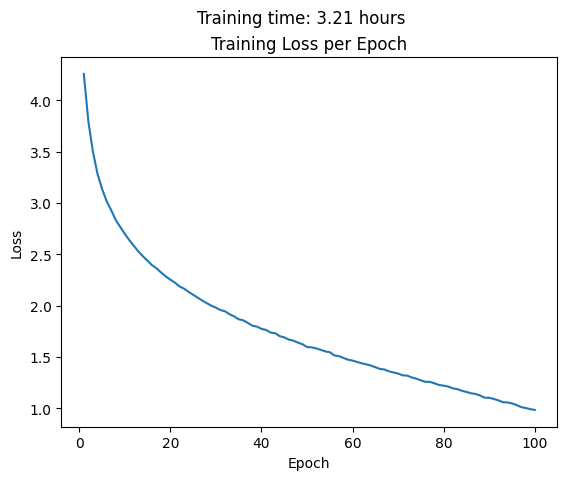

In [34]:
train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=num_epochs)

In [35]:
evaluate(model, testloader, device, folder_path)

Accuracy: 54.69%
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.83      0.71       100
           1       0.70      0.63      0.66       100
           2       0.37      0.53      0.44       100
           3       0.40      0.33      0.36       100
           4       0.36      0.41      0.38       100
           5       0.39      0.53      0.45       100
           6       0.66      0.59      0.62       100
           7       0.59      0.53      0.56       100
           8       0.66      0.60      0.63       100
           9       0.67      0.65      0.66       100
          10       0.42      0.38      0.40       100
          11       0.34      0.35      0.34       100
          12       0.53      0.68      0.59       100
          13       0.45      0.45      0.45       100
          14       0.51      0.54      0.53       100
          15       0.48      0.54      0.51       100
          16       0.53      0.58      0.